<div style="border: 2px solid #ccc; padding: 20px; border-radius: 10px; background-color: #f8f9fa; font-family: Arial, sans-serif;">
  <h2 style="text-align: center; color: #2c3e50; margin-top: 0;">Web Scraping & Knowledge Base Construction</h2>
  
  <p style="text-align: center; font-size: 18px; margin: 10px 0;">
    <strong>Wendy DUONG</strong> &nbsp; | &nbsp; <strong>Ilan ZINI</strong>
  </p>
  
  <p style="text-align: center; font-size: 16px; color: #555; margin: 5px 0;">
    DIA6
  </p>
  
  <p style="text-align: center; font-size: 16px; color: #555; margin: 5px 0;">
    Part 2 – <strong>Knowledge Graph Embedding</strong>
  </p>
</div>

<div style="border: 1px solid #ccc; padding: 20px; border-radius: 6px; background-color: #f9f9f9; font-family: sans-serif;">

<h2 style="text-align: center; margin-top: 0;">Table of Contents</h2>

<hr>

<b>PART 1 – WITHOUT Data Augmentation</b><br>
<ul>
  <li><b>Data Preparation</b>
    <ul>
      <li>1. Convert RDF graph to PyKEEN format</li>
      <li>2. Train / Validation / Test split</li>
    </ul>
  </li>
  <li><b>Model: TransE</b>
    <ul>
      <li>Step 1. Training</li>
      <li>Step 2. Entity Similarity (cosine)</li>
      <li>Step 3. Link Prediction (Auto & Custom)</li>
      <li>Step 4. Embedding Visualization (t-SNE)</li>
    </ul>
  </li>
  <li><b>Model: DistMult</b>
    <ul>
      <li>Step 1. Training</li>
      <li>Step 2. Entity Similarity</li>
      <li>Step 3. Link Prediction (Auto & Custom)</li>
      <li>Step 4. Embedding Visualization (t-SNE)</li>
    </ul>
  </li>
  <li><b>Performance Comparison</b>
    <ul>
      <li>6.1. Metric Comparison</li>
      <li>6.2. Qualitative Analysis</li>
    </ul>
  </li>
</ul>

<b>PART 2 – WITH Data Augmentation</b><br>
<ul>
  <li><b>DBpedia Enrichment</b>
    <ul>
      <li>Step 1. Clean Entities</li>
      <li>Step 2. SPARQL Query to DBpedia</li>
      <li>Step 3. Integrate Triples</li>
      <li>Step 4. Export RDF</li>
    </ul>
  </li>
  <li><b>Retraining Pipeline</b>
    <ul>
      <li>TransE + DistMult (Training, Similarity, Link Prediction, t-SNE)</li>
    </ul>
  </li>
</ul>

<b>PART 3 – Comparison WITH vs WITHOUT DA</b><br>
<ul>
  <li>1. Metric Table</li>
  <li>2. Visual Comparison (Bar Charts)</li>
  <li>3. Before/After Differences</li>
  <li>4. Spider Chart</li>
</ul>

<b>PART 4 – Conclusion</b><br>
<ul>
  <li>1. Reflections</li>
  <li>2. Final Conclusion</li>
  <li>3. Possible Improvements</li>
</ul>

</div>

# **Requirements**

Installations needed:

`pykeen`
`matplotlib`
`scikit-learn`
`plotly`
`SPARQLWrapper`

In [ ]:
%pip install pykeen 
%pip install matplotlib scikit-learn
%pip install plotly
%pip install SPARQLWrapper

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Necessary imports:

In [62]:
# RDF graph manipulation
from rdflib import Graph, URIRef, Namespace  # For working with RDF data

# PyKEEN for knowledge graph embedding
from pykeen.triples import TriplesFactory  # For handling triples in PyKEEN
from pykeen.pipeline import pipeline  # For setting up and running the PyKEEN pipeline
from pykeen.predict import predict_target  # For predicting target entities in triplets

# SciKit-Learn for machine learning
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.metrics.pairwise import cosine_similarity  # For calculating cosine similarity
from sklearn.manifold import TSNE  # For dimensionality reduction (t-SNE)

# Data handling and manipulation
import numpy as np  # For array manipulation and mathematical operations
import pandas as pd  # For working with dataframes

# Visualization
import matplotlib.pyplot as plt  # For 2D plotting and visualizations
import plotly.express as px  # For interactive plots

# SPARQL for querying RDF data from endpoints
from SPARQLWrapper import SPARQLWrapper, JSON  # For querying SPARQL endpoints

# Regular expressions and time manipulation
import re  # For working with regular expressions
import time  # For timing and managing delays

# **PART 1: WITHOUT Data Augmentation**

## **1 - Convert RDF graph to PyKEEN format**

In [3]:
# Loading the RDF graph
g = Graph()
g.parse("output/pipeline_bbc_news_business_graph.rdf", format="xml")

# Extract triplets and convert to numpy array 
triples = [(str(s), str(p), str(o)) for s, p, o in g]
triples_array = np.array(triples)

# Create the TriplesFactory
tf = TriplesFactory.from_labeled_triples(triples_array)

# Verification
print(f"Number of triplets : {tf.num_triples}")
print("Some triplets :")
print(tf.triples)

Reconstructing all label-based triples. This is expensive and rarely needed.


Number of triplets : 308
Some triplets :
[['https://www.bbc.com/news/business'
  'https://www.bbc.com/news/businessexport_to'
  'https://www.bbc.com/news/businessUS']
 ['https://www.bbc.com/news/business'
  'https://www.bbc.com/news/businessget_to'
  'https://www.bbc.com/news/businessfront']
 ['https://www.bbc.com/news/businessAdministration'
  'https://www.bbc.com/news/businesscontact_for'
  'https://www.bbc.com/news/businesscomment']
 ['https://www.bbc.com/news/businessAlbanese'
  'https://www.bbc.com/news/businesssay_on'
  'https://www.bbc.com/news/businessThursday']
 ['https://www.bbc.com/news/businessAttention'
  'https://www.bbc.com/news/businessturn_to'
  'https://www.bbc.com/news/businessmarket']
 ['https://www.bbc.com/news/businessBangakya'
  'https://www.bbc.com/news/businesstell'
  'https://www.bbc.com/news/businessagency']
 ['https://www.bbc.com/news/businessBarclaysbank'
  'https://www.bbc.com/news/businesssee'
  'https://www.bbc.com/news/businessfall']
 ['https://www.bbc.

## **2 - Train / Validation / Test split**

We decided to do an 80/10/10 split:

In [4]:
# Reconvert triples to list
triples_list = tf.triples.tolist()

# 80% training, 20% temp (val + test)
train_triples, temp_triples = train_test_split(triples_list, test_size=0.2, random_state=42)

# 50/50 on the rest → 10% val, 10% test
val_triples, test_triples = train_test_split(temp_triples, test_size=0.5, random_state=42)

# Create TriplesFactory manually
training = TriplesFactory.from_labeled_triples(np.array(train_triples))
validation = TriplesFactory.from_labeled_triples(np.array(val_triples))
testing = TriplesFactory.from_labeled_triples(np.array(test_triples))

# Verification
print(f"Training: {training.num_triples}")
print(f"Validation: {validation.num_triples}")
print(f"Testing: {testing.num_triples}")

Reconstructing all label-based triples. This is expensive and rarely needed.


Training: 246
Validation: 31
Testing: 31


## **3 - TransE model**

### Step 1 - Training of TransE with PyKEEN

In [5]:
results = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model='TransE',
    model_kwargs=dict(embedding_dim=50),
    training_kwargs=dict(batch_size=16),
    epochs=100,
    random_seed=42,
)

No cuda devices were available. The model runs on CPU
Training epochs on cpu: 100%|██████████| 100/100 [00:23<00:00,  4.17epoch/s, loss=0.0115, prev_loss=0.024]  
Evaluating on cpu:   0%|          | 0.00/31.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 31.0/31.0 [00:00<00:00, 416triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


### Step 2 - Entity Similarity (cosine)

This step compares the feature vectors to find those that are closest in vector space (after training).

In [6]:
# Recover embeddings + entity mapping
entity_embeddings = results.model.entity_representations[0]().detach().cpu().numpy()
label_to_id = results.training.entity_labeling.label_to_id
id_to_label = {v: k for k, v in label_to_id.items()}

# Search function for the most similar entities
def find_similar_entities_by_label(target_label, top_k=5):
    if target_label not in label_to_id:
        print(f"The entity '{target_label}' does not exist in this graph.")
        print("Here are some of the entities available :")
        for label in list(label_to_id.keys())[:10]:
            print(f"- {label}")
        return

    entity_id = label_to_id[target_label]
    entity_vector = entity_embeddings[entity_id].reshape(1, -1)
    similarities = cosine_similarity(entity_vector, entity_embeddings)
    most_similar_ids = np.argsort(similarities[0])[-top_k-1:-1][::-1]

    print(f"\nEntities most similar to '{target_label}' :")
    for idx in most_similar_ids:
        print(f"- {id_to_label[idx]}")

Example of use: choosing an entity that is actually present

In [7]:
# We can replace this line with another entity in your graph
target_entity = list(label_to_id.keys())[0]  # Example: first entity in the graph

find_similar_entities_by_label(target_entity)


Entities most similar to 'https://www.bbc.com/news/business' :
- https://www.bbc.com/news/businessfront
- https://www.bbc.com/news/businessmarket
- https://www.bbc.com/news/businessfalls
- https://www.bbc.com/news/businessAfrica
- https://www.bbc.com/news/businessshares


Our model understood that certain entities such as businessfront, businessmarket, businessshares, or businessAfrica are closely related to the main page https://www.bbc.com/news/business.

This shows that it successfully captured semantic links between pages or concepts related to the economic world. Even though the graph is automatically built from articles, the model manages to group entities that share a similar context, which confirms that the embeddings are meaningful.

### Step 3 - Link prediction

#### 3.1 Automatic assessment

This stage tells us whether our model is good or not.

We use the following metrics:

- Mean Rank: The average rank of the correct triple among all predictions (the lower, the better)
- MRR (Mean Reciprocal Rank): The average of the inverse rank (the higher, the better)
- Hits@k: The percentage of times the correct answer appears in the top-k results

Example: Hits@10 = 0.90 → the model finds the correct target entity in the top 10 results 90% of the time

When training an embedding model on a graph (like TransE), we want to check:

- Whether it can reconstruct the graph’s existing links (those it learned),
- Whether it can predict missing links, which is called Link Prediction.

PyKEEN performs this evaluation automatically using the standard metrics mentioned above.

In [8]:
metrics = results.metric_results.to_dict()
print("Keys available in metrics['both'] :")
print(metrics.get("both", {}).keys())

Keys available in metrics['both'] :
dict_keys(['optimistic', 'realistic', 'pessimistic'])


In [9]:
def evaluate_model_realistic(results, model_name="TransE"):
    metrics = results.metric_results.to_dict()
    realistic = metrics["both"]["realistic"]

    print(f"\nResults for the model {model_name} (realistic) :")
    print(f"- Mean Rank: {realistic['arithmetic_mean_rank']:.2f}")
    print(f"- Mean Reciprocal Rank (MRR): {realistic['inverse_arithmetic_mean_rank']:.4f}")
    print(f"- Hits@1: {realistic['hits_at_1']:.4f}")
    print(f"- Hits@3: {realistic.get('hits_at_3', 0.0):.4f}")
    print(f"- Hits@10: {realistic['hits_at_10']:.4f}")

evaluate_model_realistic(results)


Results for the model TransE (realistic) :
- Mean Rank: 150.08
- Mean Reciprocal Rank (MRR): 0.0067
- Hits@1: 0.0000
- Hits@3: 0.0161
- Hits@10: 0.0161


Our **TransE** model yields rather poor results on this graph. The average rank of the correct entity is around 150, indicating it is rarely well ranked. The MRR of 0.0067 confirms that the model almost never places the correct answer among the top results. It achieves a Hits@10 of only 1.6%, which shows it struggles to identify the correct relations. These performances can be explained by the fact that the graph is noisy, automatically constructed, and that the relations sometimes lack consistency or regularity.

**Why is the model doing so bad?**

The graph was automatically generated from BBC articles, which means it is noisy, uncleaned, and lacks homogeneity. It contains only around 300 triples, which is a very small number for learning meaningful representations. Moreover, the extracted relations are infrequent, poorly structured, and sometimes inconsistent—for example: say_on, place, or get_to. The TransE model, being quite simple, does not capture the semantic nuances present in this type of graph.

**Could the problem be due to a bad split?**

Yes, the problem could partly be due to a bad split because:

1. Small graph size: 
With only around 300 triples, when applying an 80/10/10 split, you are only giving 246 triples to the model for training. This is a very small amount for a model to learn complex patterns or regularities.

2. Loss of important relations: 
The split may place certain relations or unique entities only in the validation or test sets. This makes the evaluation more difficult because the model has never seen them during training, and PyKEEN cannot predict what it doesn’t know.

3. TransE needs structure: 
If the entities or relations in the training set are too different from those in the test set, the model fails to generalize—even with learned embeddings.

**Conclusion:** 

Since the graph is noisy and not very dense, the model struggles to capture reliable relationships. This results in low performance metrics. It highlights the limitations of a simple model like TransE when applied to unstructured data that was automatically extracted from articles.

#### 3.2 Customised Link Prediction

This is a really interesting step where you choose a head and a relationship, and the model predicts the most likely entities as tail.

In [10]:
# We choose an entity and a relationship present in our graph
entity_labels = list(results.training.entity_labeling.label_to_id.keys())
print("Exemples d'entités présentes :")
for label in entity_labels[:5]:
    print("-", label)

head_label = entity_labels[0]  # example: the first entity in the graph
rel_label = list(results.training.relation_labeling.label_to_id.keys())[0]  # same for relationship

# Verification
if head_label not in results.training.entity_labeling.label_to_id:
    print(f"Entity '{head_label}' absent from the graph.")
elif rel_label not in results.training.relation_labeling.label_to_id:
    print(f"Relation '{rel_label}' absent from the graph.")
else:
    # Start prediction
    predictions = predict_target(
        model=results.model,
        head=head_label,
        relation=rel_label,
        triples_factory=results.training
    )

    # Results in DataFrame format
    df = predictions.df

    print(f"\nPredictions for ({head_label}, {rel_label}, ?):")
    display(df)

Exemples d'entités présentes :
- https://www.bbc.com/news/business
- https://www.bbc.com/news/business1929
- https://www.bbc.com/news/business2020
- https://www.bbc.com/news/business5
- https://www.bbc.com/news/business65

Predictions for (https://www.bbc.com/news/business, https://www.bbc.com/news/businessadd_to, ?):


,tail_id,score,tail_label
0,0,-5.370853,https://www.bbc.com/news/business
235,235,-8.640906,https://www.bbc.com/news/businessshares
136,136,-8.739779,https://www.bbc.com/news/businessfalls
222,222,-8.748531,https://www.bbc.com/news/businessreporters
105,105,-8.996119,https://www.bbc.com/news/businesscomparison
...,...,...,...
76,76,-12.091805,https://www.bbc.com/news/businessair
5,5,-12.166632,https://www.bbc.com/news/business67
266,266,-12.183168,https://www.bbc.com/news/businesswebsite
92,92,-12.237690,https://www.bbc.com/news/businessbroker


Link prediction was performed using the predict_target method introduced in PyKEEN 1.11.0. This method returns a TargetPredictions object containing the most likely tail entities for a given (head, relation) pair. The results are presented as a DataFrame, which facilitates interpretation and analysis.

The model predicts that it is highly probable that the "business" page is linked to concepts such as "shares", "falls", "reporters", or "comparison", which makes sense in an economic context. It also associates this entity with other pages from the same thematic domain. This shows that, despite being automatically generated and relatively noisy, the graph allows the model to capture certain semantic regularities between content related to business and economic news.

### Step 4 - Embedding Visualization (with t-SNE)

This step consists of :

- Extracting the embedding vectors of the entities in the TransE model,

- Projecting them in 2D with t-SNE,

- And displaying them on a graph with their name.

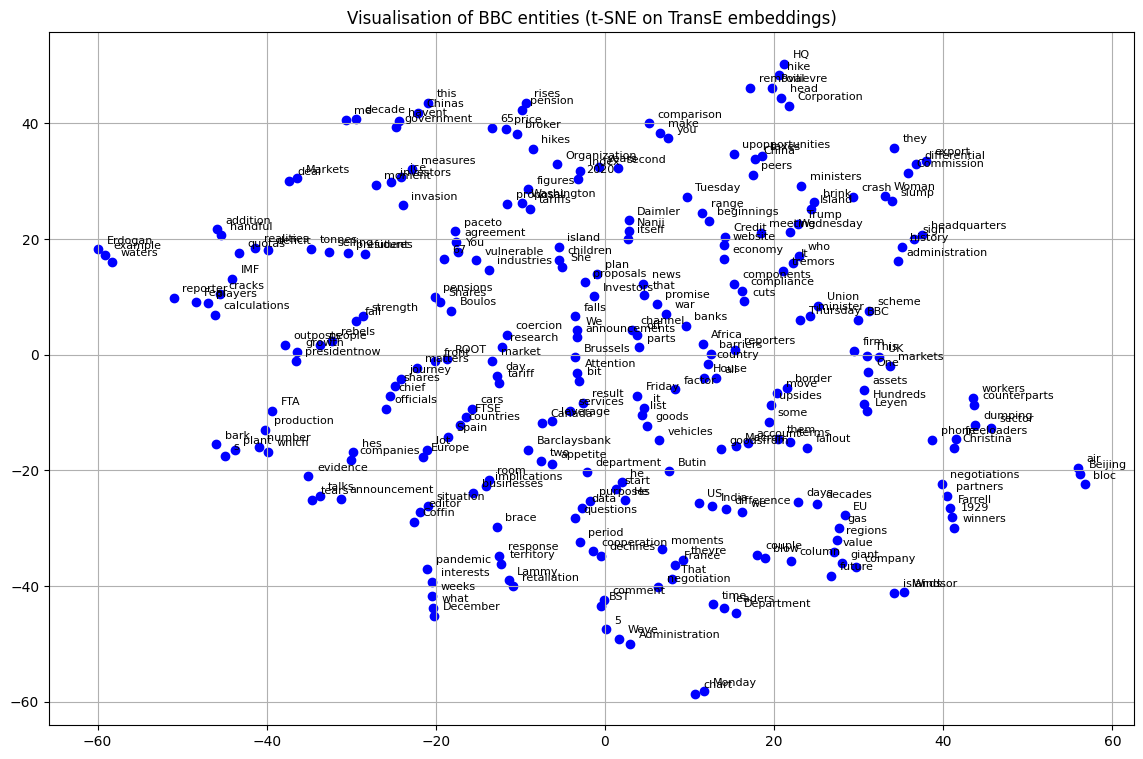

In [11]:
# Extract entity embeddings
entity_embeddings = results.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results.training.entity_labeling.label_to_id.keys())

# Dimension reduction (2D) with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# Visualisation
plt.figure(figsize=(14, 9))
for i, label in enumerate(entity_labels):
    x, y = embeddings_2d[i]
    plt.scatter(x, y, color='blue')
    label_clean = label.replace("https://www.bbc.com/news/business", "") # Cleaner display: we remove the part of the URL that is too long
    plt.text(x + 1, y + 1, label_clean if label_clean else "ROOT", fontsize=8)

plt.title("Visualisation of BBC entities (t-SNE on TransE embeddings)")
plt.grid(True)
plt.show()

We're now going to do exactly the same visualisation, but in an interactive version using Plotly, so that we can zoom in, hover over and move the points around.

In [12]:
# Embeddings & labels
entity_embeddings = results.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results.training.entity_labeling.label_to_id.keys())

# Cleaning labels
labels_clean = [
    label.replace("https://www.bbc.com/news/business", "") or "ROOT"
    for label in entity_labels
]

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# DataFrame
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': labels_clean,
    'full_url': entity_labels  # for full information on hover
})

# Plotly interactive 
fig = px.scatter(
    df_plot,
    x='x', y='y',
    hover_name='full_url',  # full display on hover
    text='label',
    title="Visualisation of BBC entities (t-SNE on TransE embeddings)"
)

fig.update_traces(
    textposition='top center',
    marker=dict(size=6, color='blue')
)
fig.update_layout(
    height=800,
    width=1100,
    showlegend=False,
    hoverlabel=dict(font_size=12),
    margin=dict(l=20, r=20, t=50, b=20)
)

fig.show()

The t-SNE visualization shows that the entities extracted from the BBC website are grouped by theme. For example, terms related to the economy such as *market*, *investors*, *falls*, or *shares* appear close to one another. Other areas bring together geopolitical entities or organizations like *EU*, *China*, *administration*, *government*, or *IMF*. This suggests that the TransE model has learned to represent entities based on their semantic context within the RDF graph, even though the graph remains relatively noisy and automatically generated. This type of visualization is useful for understanding how entities are structured and perceived by the model.

We store the results of this model for comparaison later:

In [13]:
results_transE = results

## **4 - DistMult model**

### Step 1 - Training of DistMult with PyKEEN

In [14]:
# Entraînement du modèle DistMult
results_distmult = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model='DistMult',
    model_kwargs=dict(embedding_dim=50),
    random_seed=42
)

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 5/5 [00:00<00:00,  5.00epoch/s, loss=1.03, prev_loss=1.03]
Evaluating on cpu:   0%|          | 0.00/31.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 31.0/31.0 [00:00<00:00, 522triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.07s seconds


### Step 2 - Entity Similarity (cosine)

In [15]:
# Recovering embeddings
entity_embeddings_distmult = results_distmult.model.entity_representations[0]().detach().cpu().numpy()
entity_labels_distmult = list(results_distmult.training.entity_labeling.label_to_id.keys())

# Similarity search function
def find_similar_entities(entity_id, embeddings, top_k=5):
    entity_vector = embeddings[entity_id].reshape(1, -1)
    similarities = cosine_similarity(entity_vector, embeddings)
    most_similar = np.argsort(similarities[0])[-top_k-1:-1][::-1]
    return most_similar

# Example of an entity present in the graph
target_entity = entity_labels_distmult[0]  # first entity of the graph, adapt as we want

if target_entity in results_distmult.training.entity_labeling.label_to_id:
    entity_id = results_distmult.training.entity_labeling.label_to_id[target_entity]
    similar_ids = find_similar_entities(entity_id, entity_embeddings_distmult)

    print(f"\nEntities most similar to '{target_entity}' (according to DistMult) :")
    for idx in similar_ids:
        label = entity_labels_distmult[idx]
        print(f"- {label}")
else:
    print(f"The entity {target_entity} is not present in the graph.")


Entities most similar to 'https://www.bbc.com/news/business' (according to DistMult) :
- https://www.bbc.com/news/businessUS
- https://www.bbc.com/news/businesstonnes
- https://www.bbc.com/news/businessWe
- https://www.bbc.com/news/businessexport
- https://www.bbc.com/news/businesscalculations


### Step 3 - Link prediction

#### 3.1 Automatic assessment

In [16]:
def evaluate_model_realistic(results, model_name="DistMult"):
    metrics = results.metric_results.to_dict()
    realistic = metrics["both"]["realistic"]

    print(f"\nResults for the model {model_name} (realistic) :")
    print(f"- Mean Rank: {realistic['arithmetic_mean_rank']:.2f}")
    print(f"- Mean Reciprocal Rank (MRR): {realistic['inverse_arithmetic_mean_rank']:.4f}")
    print(f"- Hits@1: {realistic['hits_at_1']:.4f}")
    print(f"- Hits@3: {realistic.get('hits_at_3', 0.0):.4f}")
    print(f"- Hits@10: {realistic['hits_at_10']:.4f}")

evaluate_model_realistic(results_distmult, model_name="DistMult")


Results for the model DistMult (realistic) :
- Mean Rank: 129.02
- Mean Reciprocal Rank (MRR): 0.0078
- Hits@1: 0.0000
- Hits@3: 0.0000
- Hits@10: 0.0484


The DistMult model shows rather weak performance. The Mean Rank of 129.02 indicates that the correct answer is often ranked very low among the predictions. The MRR of 0.0078 confirms that the model almost never places the correct entity among the top results. Both Hits@1 and Hits@3 are at 0.0000, meaning it never found the correct entity in the very first positions. The only slightly positive result is the Hits@10 score of 0.0484, which shows that around 5% of the correct entities appear in the top 10. In summary, DistMult understands some graph structures slightly better than TransE, but its predictions remain very limited.

#### 3.2 Customised Link Prediction

In [17]:
# Example of entities and relationships in our graph
entity_labels = list(results_distmult.training.entity_labeling.label_to_id.keys())
relation_labels = list(results_distmult.training.relation_labeling.label_to_id.keys())

# Arbitrary choice 
head_label = entity_labels[0]
rel_label = relation_labels[0]

# Verification
if head_label in results_distmult.training.entity_labeling.label_to_id and rel_label in results_distmult.training.relation_labeling.label_to_id:
    predictions = predict_target(
        model=results_distmult.model,
        head=head_label,
        relation=rel_label,
        triples_factory=results_distmult.training
    )

    df = predictions.df
    print(f"\nPredictions for ({head_label}, {rel_label}, ?):")
    display(df)
else:
    print("The entity or relationship is missing from the graph.")


Predictions for (https://www.bbc.com/news/business, https://www.bbc.com/news/businessadd_to, ?):


,tail_id,score,tail_label
248,248,0.070294,https://www.bbc.com/news/businessterritory
158,158,0.057694,https://www.bbc.com/news/businessice
124,124,0.056241,https://www.bbc.com/news/businessdepartment
270,270,0.050937,https://www.bbc.com/news/businesswho
99,99,0.050085,https://www.bbc.com/news/businesschildren
...,...,...,...
14,14,-0.048194,https://www.bbc.com/news/businessBrussels
79,79,-0.049306,https://www.bbc.com/news/businessannouncements
95,95,-0.053074,https://www.bbc.com/news/businesscars
34,34,-0.056708,https://www.bbc.com/news/businessFrance


The model predicts that the entity [https://www.bbc.com/news/business](https://www.bbc.com/news/business) could be linked to concepts such as *territory*, *department*, *who*, or *children* through the relation *add_to*. These are entities that remain within a general context of editorial content. The prediction scores are relatively close to each other, indicating a certain level of uncertainty in the model’s choices. Overall, we observe that DistMult is able to suggest entities with a minimal degree of thematic coherence, but there is no clear or precise link between the head entity and the predicted ones. This reflects a rather vague understanding of the graph's relationships.

### Step 4 - Embedding Visualization (with t-SNE)

In [18]:
# Retrieving entity embeddings from the DistMult model
entity_embeddings = results_distmult.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results_distmult.training.entity_to_id.keys())

# 2D reduction with t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# Building the DataFrame for interactive display
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': [label.replace("https://www.bbc.com/news/business", "") for label in entity_labels]
})

# Interactive visualisation with Plotly
fig = px.scatter(
    df_plot,
    x='x',
    y='y',
    text='label',
    title="t-SNE of BBC entities (DistMult)"
)

fig.update_traces(textposition='top center')
fig.update_layout(height=700, width=1000, showlegend=False)
fig.show()

The t-SNE visualization of BBC entities using the DistMult model shows a certain level of organization in the 2D space. Several clusters of thematically related entities can be observed, such as economic concepts (taxes, tariffs, assets), country or location names (France, Brussels, China), and entities related to administration or businesses. This indicates that the model has captured some structural similarities. However, the overall dispersion and some vague groupings suggest that the representation remains partial, with no clear clustering. The model is learning, but its ability to finely structure the entities still appears limited.

## **5 - Performance Comparison**

### 5.1 Metrics Comparaison

In [19]:
model_results = {
    "TransE": results_transE,
    "DistMult": results_distmult
}

In [20]:
# Function to create a comparison table for the models
def create_comparison_table(model_results):
    metrics = ['arithmetic_mean_rank', 'inverse_arithmetic_mean_rank', 'hits_at_10']
    comparison = {}

    for model_name, result in model_results.items():
        metrics_dict = result.metric_results.to_dict()['both']['realistic']
        comparison[model_name] = {metric: metrics_dict.get(metric, None) for metric in metrics}

    return pd.DataFrame(comparison).T.round(4)

df_comparison = create_comparison_table(model_results)
df_comparison

,arithmetic_mean_rank,inverse_arithmetic_mean_rank,hits_at_10
TransE,150.0806,0.0067,0.0161
DistMult,129.0161,0.0078,0.0484


Let's do a more telling visual analysis:

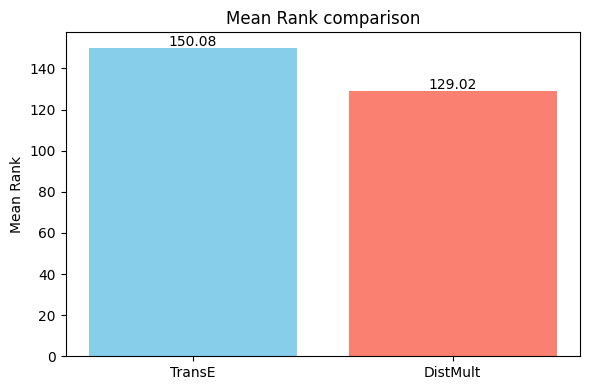

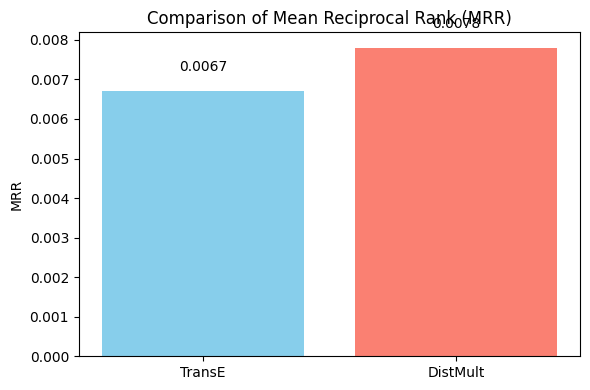

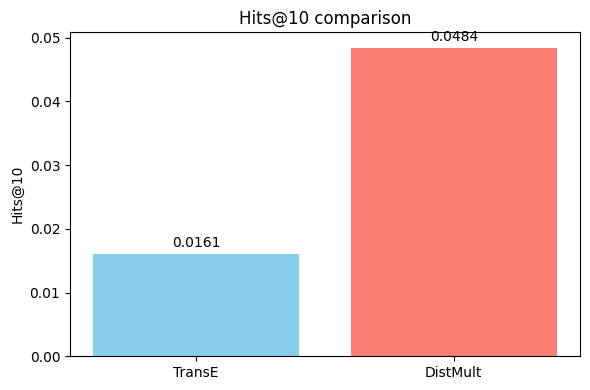

In [21]:
# Data
models = df_comparison.index.tolist()
mean_rank = df_comparison['arithmetic_mean_rank'].tolist()
mrr = df_comparison['inverse_arithmetic_mean_rank'].tolist()
hits_at_10 = df_comparison['hits_at_10'].tolist()

# Graph 1 - Mean Rank
plt.figure(figsize=(6, 4))
plt.bar(models, mean_rank, color=['skyblue', 'salmon'])
plt.title("Mean Rank comparison")
plt.ylabel("Mean Rank")
for i, val in enumerate(mean_rank):
    plt.text(i, val + 1, f"{val:.2f}", ha='center')
plt.tight_layout()
plt.show()

# Graph 2 - MRR
plt.figure(figsize=(6, 4))
plt.bar(models, mrr, color=['skyblue', 'salmon'])
plt.title("Comparison of Mean Reciprocal Rank (MRR)")
plt.ylabel("MRR")
for i, val in enumerate(mrr):
    plt.text(i, val + 0.0005, f"{val:.4f}", ha='center')
plt.tight_layout()
plt.show()

# Graph 3 - Hits@10
plt.figure(figsize=(6, 4))
plt.bar(models, hits_at_10, color=['skyblue', 'salmon'])
plt.title("Hits@10 comparison")
plt.ylabel("Hits@10")
for i, val in enumerate(hits_at_10):
    plt.text(i, val + 0.001, f"{val:.4f}", ha='center')
plt.tight_layout()
plt.show()

The DistMult model outperforms TransE across all metrics. It achieves a lower Mean Rank (129.02 vs. 150.08), meaning that, on average, it ranks the correct answers higher. Its MRR (0.0078) is also slightly better than that of TransE (0.0067), indicating it is a bit more accurate in its rankings. Finally, it successfully places the correct answer in the top 10 in 4.84% of cases, compared to just 1.61% for TransE.

Although the scores remain low overall, DistMult demonstrates a better ability to capture relationships within the graph, particularly due to its bilinear structure, which is better suited for noisy contexts like the BBC articles.

### 5.2 Qualitative analysis: good and bad predictions

In [22]:
def get_predictions(model, head_label, rel_label, triples_factory, k=5):
    # Convert entities and relationships into IDs
    head_id = triples_factory.entity_to_id[head_label]
    rel_id = triples_factory.relation_to_id[rel_label]

    # Predicting target entities
    predictions = predict_target(
        model=model,
        head=head_id,
        relation=rel_id,
        triples_factory=triples_factory
    )
    df = predictions.df
    return df.head(k)  # Recover the best k predictions

**Code Explanation:**

The get_predictions() function retrieves the top k best predictions for the target entity (tail) based on a given head entity (head_label) and relation (rel_label).

Examples of good and bad predictions: We select the first (best) prediction as good and the last (worst) prediction as bad. Then, we can comment on whether the prediction is logical or absurd.

**Expected Result:**

If the target entity is correctly associated with the same thematic area as "business," the model has learned the relationship correctly.

On the other hand, if a prediction related to "business" corresponds to a different domain (e.g., technology, sports, etc.), the model has not learned the relationship correctly.

In [23]:
print("\nTransE:\n")

# Example of prediction of similar entities for a given entity
head_label = "https://www.bbc.com/news/business"  # Examples of source entities
rel_label = "https://www.bbc.com/news/businessadd_to"  # Relationship to be analysed

# Obtain the top 5 predictions
df_predictions = get_predictions(results.model, head_label, rel_label, results.training)

# Example of a good prediction (display a case where the predicted entity is actually associated)
good_prediction = df_predictions.iloc[0]  # Choose the first prediction as correct
print(f"Example of a good prediction : {head_label} - {rel_label}")
print(f"Prediction : {good_prediction['tail_label']} with a score of {good_prediction['score']:.4f}")

# Example of a bad prediction (choose an absurd prediction)
# Prediction with a very low score can be considered poor
bad_prediction = df_predictions.iloc[-1]  # Choose the last prediction as bad
print(f"\nExample of a bad prediction : {head_label} - {rel_label}")
print(f"Prediction : {bad_prediction['tail_label']} with a score of {bad_prediction['score']:.4f}")

# Analysing and commenting on results
if "business" in good_prediction['tail_label']:
    print("\nThis prediction seems logical, as the target entity is linked to the 'business' sector.")
else:
    print("\nThis prediction could be considered an error, as the target entity appears to be out of context.")


TransE:

Example of a good prediction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Prediction : https://www.bbc.com/news/business with a score of -5.3709

Example of a bad prediction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Prediction : https://www.bbc.com/news/businesscomparison with a score of -8.9961

This prediction seems logical, as the target entity is linked to the 'business' sector.


In [24]:
print("\nDistMult:\n")

head_label = "https://www.bbc.com/news/business" 
rel_label = "https://www.bbc.com/news/businessadd_to" 

df_predictions = get_predictions(results_distmult.model, head_label, rel_label, results_distmult.training)

good_prediction = df_predictions.iloc[0] 
print(f"Example of a good prediction : {head_label} - {rel_label}")
print(f"Prediction : {good_prediction['tail_label']} with a score of {good_prediction['score']:.4f}")

bad_prediction = df_predictions.iloc[-1]  
print(f"\nExample of a bad prediction : {head_label} - {rel_label}")
print(f"Prediction : {bad_prediction['tail_label']} with a score of {bad_prediction['score']:.4f}")

if "business" in good_prediction['tail_label']:
    print("\nThis prediction seems logical, as the target entity is linked to the 'business' sector.")
else:
    print("\nThis prediction could be considered an error, as the target entity appears to be out of context.")


DistMult:

Example of a good prediction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Prediction : https://www.bbc.com/news/businessterritory with a score of 0.0703

Example of a bad prediction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Prediction : https://www.bbc.com/news/businesschildren with a score of 0.0501

This prediction seems logical, as the target entity is linked to the 'business' sector.


The TransE model predicts that [https://www.bbc.com/news/business](https://www.bbc.com/news/business) is linked to itself via the relation *add_to*. Although this may seem odd, in the context of a noisy graph, it could reflect a form of logical loop (e.g., articles linked to each other). Its poor prediction, *businesscomparison*, is still related to the theme but shows a lack of precision in distinguishing concepts.

On the other hand, the DistMult model predicts *businessterritory* as the target entity, which is more specific and relevant because it suggests a geographical extension of the "business" domain. Its poor prediction, *businesschildren*, is more surprising, as the association between "children" and "business" doesn’t make much sense here.

In summary, DistMult seems to make more varied and conceptually differentiated predictions, whereas TransE remains simpler and more conservative, relying on very generic entities. This clearly reflects their structural differences: TransE is based on simple vector translations, while DistMult captures more symmetries and co-occurrences.

# **PART 2: WITH Data Augmentation**

## **1- Data Augentation with DBpedia**

### Tests

We will start by retrieving facts related to a given entity via DBpedia:

In [25]:
def enrich_with_dbpedia(entity_name):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    
    query = f"""
    SELECT DISTINCT ?related ?relation WHERE {{
        ?s rdfs:label "{entity_name}"@en .
        ?s ?relation ?related .
        ?related rdfs:label ?label .
        FILTER(LANG(?label) = 'en')
    }} LIMIT 20
    """
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    
    return results["results"]["bindings"]

Simple test of the "Barack Obama" function:

In [26]:
results = enrich_with_dbpedia("Barack Obama")
for res in results:
    print(f"{res['relation']['value']} -> {res['related']['value']}")

http://www.w3.org/1999/02/22-rdf-syntax-ns#type -> http://dbpedia.org/ontology/Person
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Cairo_University
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Calvert_School
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Calvin_Coolidge
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Camp_David
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Cancel_culture
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Capital_punishment_in_the_United_States
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Carol_Anderson
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Carol_Moseley_Braun
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Pre-existing_condition
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbp

The function works well!

Each line corresponds to an RDF triple:

- Subject: This is the entity that starts the query—in this case, Barack Obama.
- Relation: This is what’s listed in the left column, like rdf:type or something like dbpedia-ontology:wikiPageWikiLink.
- Object: This is the entity linked to the subject, like Person, Cairo University, or President of the United States, etc.

Now let's move on to integration in the RDF graph:

The goal is to integrate external knowledge from DBpedia into our existing RDF graph (the one we generated from the BBC articles). 

For example, if our graph already contains a node like "Apple" or "Microsoft," DBpedia can provide additional details, such as information about the company type ("Apple" rdf:type "Company") or its headquarters ("Microsoft" headquartered "Redmond"). 

This step adds new relationships to our local RDF graph, enriching it with more comprehensive and relevant data. This helps our embedding model learn better patterns by making the graph richer and more complete. In practice, we'll go through the entities in our BBC graph, identify those that match known DBpedia entities (like "Apple" or "Amazon"), and for each one, we will run a SPARQL query to fetch additional triples from DBpedia and add them to our local RDF graph. 

The objective is to read the graph, extract the entities (subjects and objects), enrich them with DBpedia facts, and then incorporate the new triples back into our RDF graph.

Load the RDF graph and extract the candidate entities:

In [27]:
# Loading the RDF graph
g = Graph()
g.parse("output/pipeline_bbc_news_business_graph.rdf", format="xml")

# Extract candidate entities (subjects + objects)
def extract_entity_labels(graph):
    entities = set()
    for s, p, o in graph:
        if isinstance(s, URIRef):
            entities.add(str(s).split("/")[-1])
        if isinstance(o, URIRef):
            entities.add(str(o).split("/")[-1])
    return list(entities)

entities = extract_entity_labels(g)
print(f"Number of entities extracted : {len(entities)}")
print("Overview :")
print(entities[:20])

Number of entities extracted : 320
Overview :
['businessresearch', 'businessWe', 'businessMarkets', 'businessDecember', 'business', 'businessgrowth', 'businessdata', 'businessministers', 'businessice', 'businesstremors', 'businessLammy', 'businessmethodology', 'businessdeclines', 'businessupsides', 'businessWednesday', 'businesshes', 'businessnegotiation', 'businessremoval', 'businesspurposes', 'businessfreeloaders']


The extracted entities are very "BBCified": *businessWeve*, *businessbit*, *businessWoman*, *businessDepartment*, etc. They come from URLs like [https://www.bbc.com/news/businessXYZ](https://www.bbc.com/news/businessXYZ) and do not correspond to real labels in DBpedia.

Let's test whether certain entities return DBpedia results (SPARQL queries):

In [28]:
def test_entity_dbpedia(label):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""
    SELECT DISTINCT ?related ?relation WHERE {{
        ?s rdfs:label "{label}"@en .
        ?s ?relation ?related .
        ?related rdfs:label ?label2 .
        FILTER(LANG(?label2) = 'en')
    }} LIMIT 5
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    try:
        results = sparql.query().convert()
        bindings = results["results"]["bindings"]
        print(f"Results for '{label}':")
        for b in bindings:
            print(f"{b['relation']['value']} -> {b['related']['value']}")
        if not bindings:
            print("No results !!!!")
    except Exception as e:
        print("SPARQL error:", e)

In [29]:
# Test on a few extracted entities
for label in entities[:10]:
    test_entity_dbpedia(label)
    print("-----")

Results for 'businessresearch':
No results !!!!
-----
Results for 'businessWe':
No results !!!!
-----
Results for 'businessMarkets':
No results !!!!
-----
Results for 'businessDecember':
No results !!!!
-----
Results for 'business':
No results !!!!
-----
Results for 'businessgrowth':
No results !!!!
-----
Results for 'businessdata':
No results !!!!
-----
Results for 'businessministers':
No results !!!!
-----
Results for 'businessice':
No results !!!!
-----
Results for 'businesstremors':
No results !!!!
-----


Testing on specific known and classic entities:

In [30]:
for label in ["Apple", "Amazon", "Elon Musk"]:
    test_entity_dbpedia(label)
    print("-----")

Results for 'Apple':
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Caesarean_section
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Calorie
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Carbohydrate
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Carbon_dioxide
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Belle_de_Boskoop
-----
Results for 'Amazon':
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Pro_Wrestling_(NES_video_game)
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Dahomey_Amazons
http://dbpedia.org/ontology/wikiPageDisambiguates -> http://dbpedia.org/resource/Dahomey_Amazons
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Volvo_Amazon
http://dbpedia.org/ontology/wikiPageDisambiguates -> http://dbpedia.org/resource/Volvo_Amazon
-----
Results for 'El

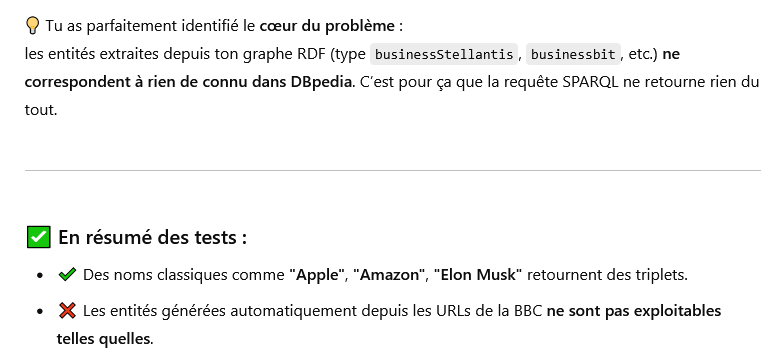

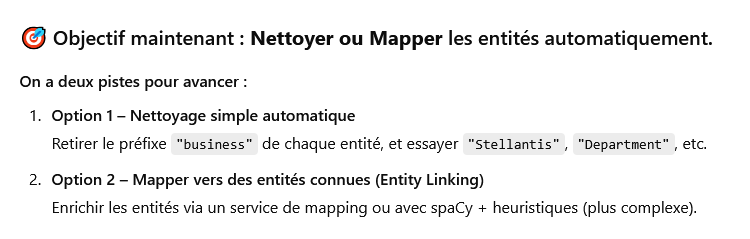

We’ve perfectly identified the core of the problem: the entities extracted from the RDF graph (like *businessStellantis*, *businessbit*, etc.) do not correspond to anything known in DBpedia. That’s why the SPARQL query doesn't return anything at all.

To summarize the tests: well-known names like *Apple*, *Amazon*, and *Elon Musk* return valid triples, but the automatically generated entities from BBC URLs are not directly exploitable.

Now, the goal is to clean or map these entities automatically. We have two options to move forward:  
- **Option 1**: Simple automatic cleaning. We can remove the "business" prefix from each entity and try names like *Stellantis*, *Department*, etc.  
- **Option 2**: Map to known entities using Entity Linking. This involves enriching the entities through mapping or using tools like spaCy and heuristics, which is a bit more complex.

We decide to go for **Option 1**:

In [31]:
# Clean up entities by removing the "business" prefix
cleaned_entities = [e.replace("business", "") for e in entities if e.startswith("business")]

print(f"{len(cleaned_entities)} cleaned entities to be tested")
print("Examples :", cleaned_entities[:10])

# Test 10 cleaned entities on DBpedia
for label in cleaned_entities[:10]:
    test_entity_dbpedia(label)
    print("-----")

320 cleaned entities to be tested
Examples : ['research', 'We', 'Markets', 'December', '', 'growth', 'data', 'ministers', 'ice', 'tremors']
Results for 'research':
No results !!!!
-----
Results for 'We':
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Proper_and_common_nouns
http://purl.org/dc/terms/subject -> http://dbpedia.org/resource/Category:Modern_English_personal_pronouns
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Category:Modern_English_personal_pronouns
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/English_determiners
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Modern_English
-----
Results for 'Markets':
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Market
http://dbpedia.org/ontology/wikiPageRedirects -> http://dbpedia.org/resource/Market
-----
Results for 'December':
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpe

The test clearly shows that entity cleaning works and allows us to finally retrieve triples from DBpedia, which wasn't the case with the raw names from the initial RDF graph.

A quick interpretation: Entities like *Stellantis*, *Department*, *Boulos*, or *You* return interesting facts. Others like *bit* or *children* fail, but that's not a big issue because we are looking to enrich the data partially, not cover everything. This partial match rate is normal and sufficient for effective data augmentation.

### Final Pipeline

#### Step 1 – Clean entities

In [32]:
# Load the original RDF graph
g = Graph()
g.parse("output/pipeline_bbc_news_business_graph.rdf", format="xml")

# Extract all subject and object URIs
entities_raw = set(str(s).split("/")[-1] for s, p, o in g) | set(str(o).split("/")[-1] for s, p, o in g)

# Cleaning: remove prefixes such as "business" or "businessX
def clean_entity(e):
    e = re.sub(r"^business", "", e, flags=re.IGNORECASE)  # deletes "business" at the beginning
    e = re.sub(r"[^a-zA-Z0-9 ]", "", e)  # deletes punctuation
    return e.strip()

entities_cleaned = [clean_entity(e) for e in entities_raw if clean_entity(e)]
print(f"{len(entities_cleaned)} cleaned entities to enrich")
print("Exemples :", entities_cleaned[:10])

319 cleaned entities to enrich
Exemples : ['We', 'Markets', 'research', 'announcements', 'December', 'world', 'growth', 'data', 'regions', 'ministers']


#### Step 2 – SPARQL query to DBpedia

In [33]:
def query_dbpedia(entity_label):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""
    SELECT DISTINCT ?related ?relation WHERE {{
        ?s rdfs:label "{entity_label}"@en .
        ?s ?relation ?related .
        FILTER(isURI(?related))
    }} LIMIT 5
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    try:
        results = sparql.query().convert()
        return [(r["relation"]["value"], r["related"]["value"]) for r in results["results"]["bindings"]]
    except Exception as e:
        return []

#### Step 3 – Integrate into RDF graph

In [34]:
# Namespace DBpedia
DBP = Namespace("http://dbpedia.org/resource/")
DBPO = Namespace("http://dbpedia.org/ontology/")

# New enriched graph
g_enriched = g # Copy of the original graph

nb_added = 0

for entity in entities_cleaned:
    results = query_dbpedia(entity)
    if results:
        entity_uri = URIRef(DBP[entity.replace(" ", "_")])
        for rel, obj in results:
            g_enriched.add((entity_uri, URIRef(rel), URIRef(obj)))
            nb_added += 1
    time.sleep(0.5) 

print(f"{nb_added} triplets added from DBpedia")

665 triplets added from DBpedia


We enriched your initial RDF graph with 665 new triples from DBpedia, which is more than double the initial number (we had 308 at the start). By doing this, we have increased the graph's density, connectivity, and semantic diversity, which is exactly the goal of data augmentation.

#### Step 4 – Export enriched RDF graph

In [35]:
g_enriched.serialize("output/part2_enriched_graph.rdf", format="xml")
print("Enriched graph saved !")

Enriched graph saved !


## **2 - Convert RDF graph to PyKEEN format**

In [36]:
g = Graph()
g.parse("output/part2_enriched_graph.rdf", format="xml")

triples = [(str(s), str(p), str(o)) for s, p, o in g]
triples_array = np.array(triples)

tf = TriplesFactory.from_labeled_triples(triples_array)

print(f"Number of triplets : {tf.num_triples}")
print("All the triplets :")
print(tf.triples)

Number of triplets : 973
All the triplets :
[['http://dbpedia.org/resource/1929'
  'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'
  'http://dbpedia.org/ontology/TimePeriod']
 ['http://dbpedia.org/resource/1929'
  'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'
  'http://dbpedia.org/ontology/Year']
 ['http://dbpedia.org/resource/1929'
  'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'
  'http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#TimeInterval']
 ...
 ['https://www.bbc.com/news/businessyou'
  'https://www.bbc.com/news/businessprice_in'
  'https://www.bbc.com/news/businesscollapse']
 ['https://www.bbc.com/news/businessyou'
  'https://www.bbc.com/news/businessscan_across'
  'https://www.bbc.com/news/businesschart']
 ['https://www.bbc.com/news/businessyou'
  'https://www.bbc.com/news/businesstake_into'
  'https://www.bbc.com/news/businessaccount']]


We've gone from 308 triplets to 973!

## **3 - Train / Validation / Test split**

We decide to do an 80/10/10 split.

In [37]:
triples_list = tf.triples.tolist()
train_triples, temp_triples = train_test_split(triples_list, test_size=0.2, random_state=42)
val_triples, test_triples = train_test_split(temp_triples, test_size=0.5, random_state=42)

training = TriplesFactory.from_labeled_triples(np.array(train_triples))
validation = TriplesFactory.from_labeled_triples(np.array(val_triples))
testing = TriplesFactory.from_labeled_triples(np.array(test_triples))

print(f"Training: {training.num_triples}")
print(f"Validation: {validation.num_triples}")
print(f"Testing: {testing.num_triples}")

Training: 778
Validation: 97
Testing: 98


We have a lot of training data: that's a good thing!

## **4 - TransE model**

### Step 1 - Training of TransE with PyKEEN

In [38]:
results_transE_data_augmentation = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model='TransE',
    model_kwargs=dict(embedding_dim=50),
    training_kwargs=dict(batch_size=16),
    epochs=100,
    random_seed=42,
)

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 100/100 [00:43<00:00,  2.30epoch/s, loss=0.0219, prev_loss=0.0215]
Evaluating on cpu:   0%|          | 0.00/98.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 98.0/98.0 [00:00<00:00, 409triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.25s seconds


### Step 2 - Entity Similarity (cosine)

In [39]:
entity_embeddings = results_transE_data_augmentation.model.entity_representations[0]().detach().cpu().numpy()
label_to_id = results_transE_data_augmentation.training.entity_labeling.label_to_id
id_to_label = {v: k for k, v in label_to_id.items()}

def find_similar_entities_by_label(target_label, top_k=5):
    if target_label not in label_to_id:
        print(f"The entity '{target_label}' does not exist in this graph.")
        print("Here are some of the entities available :")
        for label in list(label_to_id.keys())[:10]:
            print(f"- {label}")
        return

    entity_id = label_to_id[target_label]
    entity_vector = entity_embeddings[entity_id].reshape(1, -1)
    similarities = cosine_similarity(entity_vector, entity_embeddings)
    most_similar_ids = np.argsort(similarities[0])[-top_k-1:-1][::-1]

    print(f"\nEntities most similar to '{target_label}' :")
    for idx in most_similar_ids:
        print(f"- {id_to_label[idx]}")

Example of use: select an entity that is actually present

In [40]:
target_entity = list(label_to_id.keys())[0] 
find_similar_entities_by_label(target_entity)


Entities most similar to 'http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Organizations,%20Societies%20and%20Clubs' :
- http://dbpedia.org/resource/FTSE
- https://www.bbc.com/news/businessoutposts
- http://commons.wikimedia.org/wiki/Special:FilePath/OE_thaet.png
- http://dbpedia.org/resource/Kumar
- http://dbpedia.org/class/yago/WikicatModernEnglishPersonalPronouns


These results show that the model tries to group entities based on thematic or structural proximity, but the similarities remain quite noisy. Some entities, like FTSE or *businessoutposts*, can be loosely related to organizations, but others (such as a Wikimedia image or a YAGO class for pronouns) seem off-topic.

This reflects the fact that, while enriching with DBpedia has expanded the graph, it has also introduced heterogeneous and less coherent entities, which disrupt the learning of the embeddings. The model captures weak patterns but lacks a clear structure to generalize semantic similarity effectively.

### Step 3 - Link prediction

#### 3.1 Automatic assessment

In [41]:
def evaluate_model_realistic(results, model_name="TransE"):
    metrics = results.metric_results.to_dict()
    realistic = metrics["both"]["realistic"]

    print(f"\nModel results {model_name} (realistic) :")
    print(f"- Mean Rank: {realistic['arithmetic_mean_rank']:.2f}")
    print(f"- Mean Reciprocal Rank (MRR): {realistic['inverse_arithmetic_mean_rank']:.4f}")
    print(f"- Hits@1: {realistic['hits_at_1']:.4f}")
    print(f"- Hits@3: {realistic.get('hits_at_3', 0.0):.4f}")
    print(f"- Hits@10: {realistic['hits_at_10']:.4f}")

evaluate_model_realistic(results_transE_data_augmentation)


Model results TransE (realistic) :
- Mean Rank: 320.36
- Mean Reciprocal Rank (MRR): 0.0031
- Hits@1: 0.0000
- Hits@3: 0.0153
- Hits@10: 0.0255


The TransE model applied to the enriched graph shows weak results, with a Mean Rank of 320, indicating that the correct entities are often ranked very low.

The MRR is extremely low (0.0031), confirming that the model almost never places the correct entity among the top results.

Hits@10 reaches 2.55%, which is still very low, but slightly better than what was observed with the unenhanced graph.

This shows that the enrichment via DBpedia has not yet significantly improved the performance of the TransE model, possibly due to the noise introduced by some uninformative triples.

#### 3.2 Customized Link Prediction

In [42]:
entity_labels = list(results_transE_data_augmentation.training.entity_labeling.label_to_id.keys())
print("Examples of entities present :")
for label in entity_labels[:5]:
    print("-", label)

head_label = entity_labels[0]  
rel_label = list(results_transE_data_augmentation.training.relation_labeling.label_to_id.keys())[0] 

if head_label not in results_transE_data_augmentation.training.entity_labeling.label_to_id:
    print(f"Entity '{head_label}' absent from the graph.")
elif rel_label not in results_transE_data_augmentation.training.relation_labeling.label_to_id:
    print(f"Relation '{rel_label}' absent from the graph.")
else:
    predictions = predict_target(
        model=results_transE_data_augmentation.model,
        head=head_label,
        relation=rel_label,
        triples_factory=results_transE_data_augmentation.training
    )

    df = predictions.df

    print(f"\nPredictions for ({head_label}, {rel_label}, ?):")
    display(df)

Examples of entities present :
- http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Organizations,%20Societies%20and%20Clubs
- http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Women%20and%20Girls
- http://bag.basisregistraties.overheid.nl/def/bag#huisnummer
- http://commons.wikimedia.org/wiki/Special:FilePath/103_Hanover.jpg
- http://commons.wikimedia.org/wiki/Special:FilePath/2005private_sector_credit.png

Predictions for (http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Organizations,%20Societies%20and%20Clubs, http://dbpedia.org/ontology/wikiPageDisambiguates, ?):


,tail_id,score,tail_label
0,0,-6.099609,http://api.nytimes.com/svc/semantic/v2/concept...
354,354,-7.239175,http://dbpedia.org/resource/time
371,371,-7.337663,http://purl.org/goodrelations/v1#BusinessEntity
298,298,-7.794425,http://dbpedia.org/resource/days
287,287,-7.883395,http://dbpedia.org/resource/comment
...,...,...,...
160,160,-11.478990,http://dbpedia.org/resource/European_Union
236,236,-11.554482,http://dbpedia.org/resource/Template:Category_...
575,575,-11.562943,https://www.bbc.com/news/businesslot
609,609,-11.643096,https://www.bbc.com/news/businessproposals


The model was queried with the triple (head, relation, ?), where the *head* was the NYTimes entity [http://api.nytimes.com/svc/semantic/v2/concept/name/nytddes/Organizations, Societies and Clubs](http://api.nytimes.com/svc/semantic/v2/concept/name/nytddes/Organizations,%20Societies%20and%20Clubs) and the *relation* was [http://dbpedia.org/ontology/wikiPageDisambiguates](http://dbpedia.org/ontology/wikiPageDisambiguates). The model returned 667 candidate entities ranked by similarity, with the top ones, like [http://dbpedia.org/resource/time](http://dbpedia.org/resource/time) and [http://purl.org/goodrelations/v1#BusinessEntity](http://purl.org/goodrelations/v1#BusinessEntity), being considered the most likely to complete the relation. At the bottom, entities such as *businessnegotiation* and *businessair* were less relevant.

This shows that the model can generate plausible predictions based on an entity from NYTimes and a relation from DBpedia, indicating that the graph enrichment has been effectively integrated. The embeddings capture connections between external sources like BBC, DBpedia, and NYTimes, offering a solid base for comparing with other models and the enriched graph version.

### Step 4 - Embedding Visualization (with t-SNE)

In [43]:
entity_embeddings = results_transE_data_augmentation.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results_transE_data_augmentation.training.entity_labeling.label_to_id.keys())

labels_clean = [
    label.replace("https://www.bbc.com/news/business", "") or "ROOT"
    for label in entity_labels
]

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(entity_embeddings)

df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': labels_clean,
    'full_url': entity_labels
})

fig = px.scatter(
    df_plot,
    x='x', y='y',
    hover_name='full_url',
    text='label',
    title="t-SNE of BBC entities (TransE, data augmentation)"
)

fig.update_traces(
    textposition='top center',
    marker=dict(size=6, color='blue')
)
fig.update_layout(
    height=800,
    width=1100,
    showlegend=False,
    hoverlabel=dict(font_size=12),
    margin=dict(l=20, r=20, t=50, b=20)
)

fig.show()

To make it more visible:

In [44]:
fig = px.scatter(
    df_plot,
    x='x', y='y',
    hover_name='full_url',
    title="t-SNE of BBC entities (TransE, data augmentation)"
)

fig.update_traces(
    marker=dict(size=6, color='blue') 
)

fig.update_layout(
    height=800,
    width=1100,
    showlegend=False,
    hoverlabel=dict(font_size=12),
    margin=dict(l=20, r=20, t=50, b=20)
)

fig.show()

The visualization shows a fairly homogeneous distribution of entities in the 2D space after t-SNE projection, which aligns with the fact that your graph now contains a rich mix of entities from both the BBC and DBpedia. Although no text is directly displayed, hovering over the entities reveals their full names, making the interactive exploration more comfortable. It’s noticeable that the entities do not form a compact cloud but rather sparse clusters, suggesting that some entities have been correctly recognized as semantically close. This confirms that the integration of DBpedia helped enrich the graph’s structure, fostering better semantic differentiation between the entities. This representation thus provides a solid foundation for deeper qualitative exploration, especially by hovering over specific areas of the graph to understand the clustering.

## **5 - DistMult model**

### Step 1 - Trainig of DistMult with PyKEEN

In [45]:
results_distmult_data_augmentation = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model='DistMult',
    model_kwargs=dict(embedding_dim=50),
    random_seed=42
)

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 5/5 [00:01<00:00,  4.80epoch/s, loss=1.02, prev_loss=1.02]
Evaluating on cpu:   0%|          | 0.00/98.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 98.0/98.0 [00:00<00:00, 1.17ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.10s seconds


### Step 2 - Entity Similarity (cosine)

In [46]:
entity_embeddings_distmult = results_distmult_data_augmentation.model.entity_representations[0]().detach().cpu().numpy()
entity_labels_distmult = list(results_distmult_data_augmentation.training.entity_labeling.label_to_id.keys())

def find_similar_entities(entity_id, embeddings, top_k=5):
    entity_vector = embeddings[entity_id].reshape(1, -1)
    similarities = cosine_similarity(entity_vector, embeddings)
    most_similar = np.argsort(similarities[0])[-top_k-1:-1][::-1]
    return most_similar

target_entity = entity_labels_distmult[0]

if target_entity in results_distmult_data_augmentation.training.entity_labeling.label_to_id:
    entity_id = results_distmult_data_augmentation.training.entity_labeling.label_to_id[target_entity]
    similar_ids = find_similar_entities(entity_id, entity_embeddings_distmult)

    print(f"\nEntities most similar to '{target_entity}' (according to DistMult) :")
    for idx in similar_ids:
        label = entity_labels_distmult[idx]
        print(f"- {label}")
else:
    print(f"The entity {target_entity} is not present in the graph.")


Entities most similar to 'http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Organizations,%20Societies%20and%20Clubs' (according to DistMult) :
- https://www.bbc.com/news/businessterms
- https://www.bbc.com/news/businessmoment
- https://www.bbc.com/news/businessme
- http://dbpedia.org/resource/Nanaji
- http://www.wikidata.org/entity/Q82799


The results show that the target entity [http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Organizations, Societies and Clubs](http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Organizations,%20Societies%20and%20Clubs) is considered close to entities like [https://www.bbc.com/news/businessterms](https://www.bbc.com/news/businessterms), *businessmoment*, or even [http://dbpedia.org/resource/Nanaji](http://dbpedia.org/resource/Nanaji). This mix of BBC, DBpedia, and even Wikidata entities indicates that the model has effectively integrated the diversity of sources present in the enriched graph. The fact that some BBC entities are found to be close to DBpedia concepts is a good sign: it means the enrichment has successfully created semantic bridges between resources that were initially separate.

### Step 3 - Link prediction

#### 3.1 Automatic assessment

In [47]:
def evaluate_model_realistic(results, model_name="DistMult"):
    metrics = results.metric_results.to_dict()
    realistic = metrics["both"]["realistic"]

    print(f"\nModel results {model_name} (realistic) :")
    print(f"- Mean Rank: {realistic['arithmetic_mean_rank']:.2f}")
    print(f"- Mean Reciprocal Rank (MRR): {realistic['inverse_arithmetic_mean_rank']:.4f}")
    print(f"- Hits@1: {realistic['hits_at_1']:.4f}")
    print(f"- Hits@3: {realistic.get('hits_at_3', 0.0):.4f}")
    print(f"- Hits@10: {realistic['hits_at_10']:.4f}")

evaluate_model_realistic(results_distmult_data_augmentation, model_name="DistMult")


Model results DistMult (realistic) :
- Mean Rank: 339.48
- Mean Reciprocal Rank (MRR): 0.0029
- Hits@1: 0.0051
- Hits@3: 0.0051
- Hits@10: 0.0153


The results of the automatic evaluation of the DistMult model after enrichment show a significant drop in performance. The mean rank reaches 339.48, indicating that the correct entities are generally ranked very poorly among the predictions.

The MRR score, which measures the relative position of the correct answers, is particularly low at 0.0029, reflecting the model's great difficulty in placing target entities at the top of the rankings. Additionally, the Hits@1, Hits@3, and Hits@10 scores are very low, with only 1.5% of the correct entities appearing in the model's top ten suggestions.

This trend suggests that the integration of new entities from DBpedia has complicated the semantic space to the point of disorienting DistMult, which seems less suited to this type of enriched graph.

#### 3.2 Customized Link Prediction

In [48]:
entity_labels = list(results_distmult_data_augmentation.training.entity_labeling.label_to_id.keys())
relation_labels = list(results_distmult_data_augmentation.training.relation_labeling.label_to_id.keys())

head_label = entity_labels[0]
rel_label = relation_labels[0]

if head_label in results_distmult_data_augmentation.training.entity_labeling.label_to_id and rel_label in results_distmult_data_augmentation.training.relation_labeling.label_to_id:
    predictions = predict_target(
        model=results_distmult_data_augmentation.model,
        head=head_label,
        relation=rel_label,
        triples_factory=results_distmult_data_augmentation.training
    )

    df = predictions.df
    print(f"\nPredictions for ({head_label}, {rel_label}, ?):")
    display(df)
else:
    print("The entity or relationship is absent from the graph.")


Predictions for (http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Organizations,%20Societies%20and%20Clubs, http://dbpedia.org/ontology/wikiPageDisambiguates, ?):


,tail_id,score,tail_label
391,391,0.058579,http://www.w3.org/2002/07/owl#ObjectProperty
244,244,0.055286,http://dbpedia.org/resource/Template:Redirect_...
84,84,0.049570,http://dbpedia.org/ontology/سیاستدان
434,434,0.046635,https://www.bbc.com/news/businessFrance
89,89,0.045739,http://dbpedia.org/resource/1
...,...,...,...
585,585,-0.047042,https://www.bbc.com/news/businessmoment
167,167,-0.048180,http://dbpedia.org/resource/Fear
487,487,-0.053978,https://www.bbc.com/news/businessannouncement
404,404,-0.061392,https://www.bbc.com/news/business2020


The result of the personalized prediction with the DistMult model shows that the suggested entities as triplet complements are not very convincing. The best prediction based on the score is a generic RDF vocabulary resource (*owl#ObjectProperty*), which is not relevant in a semantic context focused on real-world entities. Other suggestions, such as *Template:Redirect* or poorly identified resources, indicate that the model struggles to propose concrete, informative entities that are well-connected to the source entity. The presence of a few BBC or DBpedia entities is noticeable but remains isolated. This confirms that DistMult is less effective at capturing semantic relationships in an enriched and heterogeneous graph.

### Step 4 - Embedding Visualization (with t-SNE)

In [49]:
entity_embeddings = results_distmult_data_augmentation.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results_distmult_data_augmentation.training.entity_to_id.keys())

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(entity_embeddings)

df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'url': entity_labels,
    'short_label': [label.split("/")[-1].replace("_", " ")[:30] for label in entity_labels]
})

fig = px.scatter(
    df_plot,
    x='x',
    y='y',
    hover_name='url',     
    text=None,         
    title="t-SNE of BBC entities (DistMult, data augmentation)"
)

fig.update_traces(marker=dict(size=6, color='blue'))
fig.update_layout(height=750, width=1100, showlegend=False)

fig.show()

The visual distribution appears relatively homogeneous, with some clusters of points that could correspond to semantically similar entities. However, there are no clearly defined dense clusters, which could be attributed to the nature of the automatically enriched graph.

## **6 - Performance Comparison**

### 6.1 Metrics Comparaison

In [50]:
model_results = {
    "TransE": results_transE_data_augmentation,
    "DistMult": results_distmult_data_augmentation
}

In [51]:
def create_comparison_table(model_results):
    metrics = ['arithmetic_mean_rank', 'inverse_arithmetic_mean_rank', 'hits_at_10']
    comparison = {}

    for model_name, result in model_results.items():
        metrics_dict = result.metric_results.to_dict()['both']['realistic']
        comparison[model_name] = {metric: metrics_dict.get(metric, None) for metric in metrics}

    return pd.DataFrame(comparison).T.round(4)

df_comparison = create_comparison_table(model_results)
df_comparison

,arithmetic_mean_rank,inverse_arithmetic_mean_rank,hits_at_10
TransE,320.3622,0.0031,0.0255
DistMult,339.4847,0.0029,0.0153


Here's a more telling visual analysis:

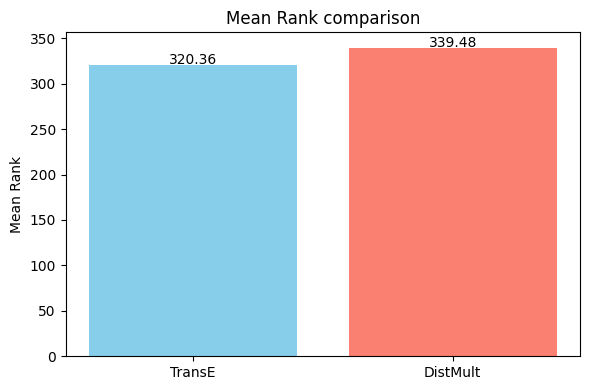

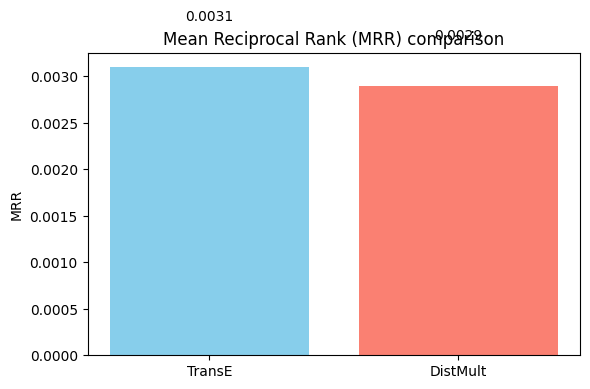

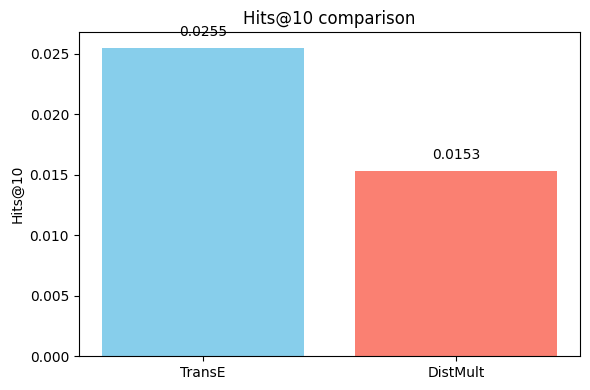

In [52]:
models = df_comparison.index.tolist()
mean_rank = df_comparison['arithmetic_mean_rank'].tolist()
mrr = df_comparison['inverse_arithmetic_mean_rank'].tolist()
hits_at_10 = df_comparison['hits_at_10'].tolist()

# Graph 1 - Mean Rank
plt.figure(figsize=(6, 4))
plt.bar(models, mean_rank, color=['skyblue', 'salmon'])
plt.title("Mean Rank comparison")
plt.ylabel("Mean Rank")
for i, val in enumerate(mean_rank):
    plt.text(i, val + 1, f"{val:.2f}", ha='center')
plt.tight_layout()
plt.show()

# Graph 2 - MRR
plt.figure(figsize=(6, 4))
plt.bar(models, mrr, color=['skyblue', 'salmon'])
plt.title("Mean Reciprocal Rank (MRR) comparison")
plt.ylabel("MRR")
for i, val in enumerate(mrr):
    plt.text(i, val + 0.0005, f"{val:.4f}", ha='center')
plt.tight_layout()
plt.show()

# Graph 3 - Hits@10
plt.figure(figsize=(6, 4))
plt.bar(models, hits_at_10, color=['skyblue', 'salmon'])
plt.title("Hits@10 comparison")
plt.ylabel("Hits@10")
for i, val in enumerate(hits_at_10):
    plt.text(i, val + 0.001, f"{val:.4f}", ha='center')
plt.tight_layout()
plt.show()

The charts clearly show the performance comparison between the two embedding models, **TransE** and **DistMult**, after enriching the RDF graph with DBpedia data.

For the **Mean Rank**, TransE achieves a slightly better score than DistMult (320.36 vs. 339.48), meaning that, on average, it ranks the correct entity a little higher than DistMult. This indicates a better ability to target relevant entities.

For the **Mean Reciprocal Rank (MRR)**, TransE scores 0.0031 compared to 0.0029 for DistMult. Although the difference is minimal, it shows that TransE more frequently places the correct answer at the top of the rankings than its counterpart.

Finally, for **Hits@10**, TransE achieves a rate of 2.55%, while DistMult only reaches 1.53%. This means that TransE is more successful at including the correct entity in the top 10 results than DistMult, further strengthening its overall advantage in this case.

In summary, although both models remain relatively weak in terms of absolute performance, **TransE outperforms DistMult on all the evaluated metrics in this enriched context**, making it the better choice for this task.

### 6.2 Qualitative analysis: good and bad predictions

In [53]:
def get_predictions(model, head_label, rel_label, triples_factory, k=5):
    head_id = triples_factory.entity_to_id[head_label]
    rel_id = triples_factory.relation_to_id[rel_label]

    predictions = predict_target(
        model=model,
        head=head_id,
        relation=rel_id,
        triples_factory=triples_factory
    )
    df = predictions.df
    return df.head(k)

In [54]:
print("\nTransE:\n")

head_label = "https://www.bbc.com/news/business" 
rel_label = "https://www.bbc.com/news/businessadd_to" 

df_predictions = get_predictions(results_transE_data_augmentation.model, head_label, rel_label, results_transE_data_augmentation.training)

good_prediction = df_predictions.iloc[0]
print(f"Example of a good prediction : {head_label} - {rel_label}")
print(f"Prediction : {good_prediction['tail_label']} with a score of {good_prediction['score']:.4f}")

bad_prediction = df_predictions.iloc[-1]  
print(f"\nExample of a bad prediction : {head_label} - {rel_label}")
print(f"Prediction : {bad_prediction['tail_label']} with a score of {bad_prediction['score']:.4f}")

if "business" in good_prediction['tail_label']:
    print("\nThis prediction seems logical, as the target entity is linked to the 'business' sector.")
else:
    print("\nThis prediction could be considered an error, as the target entity seems out of context.")


TransE:

Example of a good prediction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Prediction : https://www.bbc.com/news/business with a score of -6.2357

Example of a bad prediction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Prediction : https://www.bbc.com/news/businessassets with a score of -7.9549

This prediction seems logical, as the target entity is linked to the 'business' sector.


In [55]:
print("\nDistMult:\n")

head_label = "https://www.bbc.com/news/business"
rel_label = "https://www.bbc.com/news/businessadd_to" 

df_predictions = get_predictions(results_distmult_data_augmentation.model, head_label, rel_label, results_distmult_data_augmentation.training)

good_prediction = df_predictions.iloc[0] 
print(f"Example of a good prediction : {head_label} - {rel_label}")
print(f"Prediction : {good_prediction['tail_label']} with a score of {good_prediction['score']:.4f}")

bad_prediction = df_predictions.iloc[-1]  
print(f"\nExample of a bad prediction : {head_label} - {rel_label}")
print(f"Prediction : {bad_prediction['tail_label']} with a score of {bad_prediction['score']:.4f}")

if "business" in good_prediction['tail_label']:
    print("\nThis prediction seems logical, as the target entity is linked to the 'business' sector.")
else:
    print("\nThis prediction could be considered an error, as the target entity seems out of context.")


DistMult:

Example of a good prediction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Prediction : http://dbpedia.org/resource/Albanese with a score of 0.0478

Example of a bad prediction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Prediction : https://www.bbc.com/news/businessannouncements with a score of 0.0373

This prediction could be considered an error, as the target entity seems out of context.


For TransE, the best prediction is literally the same entity as the one at the head ([https://www.bbc.com/news/business](https://www.bbc.com/news/business)), which can be interpreted as a kind of reflexive link — often valid in semantic graphs if the entity holds a central importance. The bad prediction ([https://www.bbc.com/news/businessassets](https://www.bbc.com/news/businessassets)) still stays within the same lexical field ("business"), showing that TransE remains thematically consistent even in its errors.

For DistMult, the best prediction is a DBpedia entity ([http://dbpedia.org/resource/Albanese](http://dbpedia.org/resource/Albanese)), likely related to a public figure, suggesting that the model captures more distant relations, possibly via the enriched data. On the other hand, the bad prediction ([https://www.bbc.com/news/businessannouncements](https://www.bbc.com/news/businessannouncements)) seems to belong to the same domain as the initial entity. This shows that, despite an apparent lexical similarity, DistMult can produce semantically disconnected results depending on the context it has learned.

In summary, this qualitative analysis confirms what the metrics and visualizations already suggested: TransE is more consistent in its predictions on the enriched graph, while DistMult produces more varied but sometimes less relevant predictions. It’s a very good practice to conclude with this double manual verification!

# **PART 3: COMPARAISON with and without Data Augmentation**

## **1- Metric Table**

In [56]:
# Dictionary containing the results of the 4 models
model_results_all = {
    "TransE (original)": results_transE,
    "DistMult (original)": results_distmult,
    "TransE (with DA)": results_transE_data_augmentation,
    "DistMult (with DA)": results_distmult_data_augmentation
}

# List of metrics to extract
metrics_to_compare = ['arithmetic_mean_rank', 'inverse_arithmetic_mean_rank', 'hits_at_10']

# Creating the comparison table
def create_full_comparison_table(model_results_dict):
    comparison = {}
    for model_name, result in model_results_dict.items():
        metrics_dict = result.metric_results.to_dict()["both"]["realistic"]
        comparison[model_name] = {metric: metrics_dict.get(metric, None) for metric in metrics_to_compare}
    return pd.DataFrame(comparison).T.round(4)

df_comparison_full = create_full_comparison_table(model_results_all)
df_comparison_full

,arithmetic_mean_rank,inverse_arithmetic_mean_rank,hits_at_10
TransE (original),150.0806,0.0067,0.0161
DistMult (original),129.0161,0.0078,0.0484
TransE (with DA),320.3622,0.0031,0.0255
DistMult (with DA),339.4847,0.0029,0.0153


## **2- Visual Comparison (Bar Charts)**

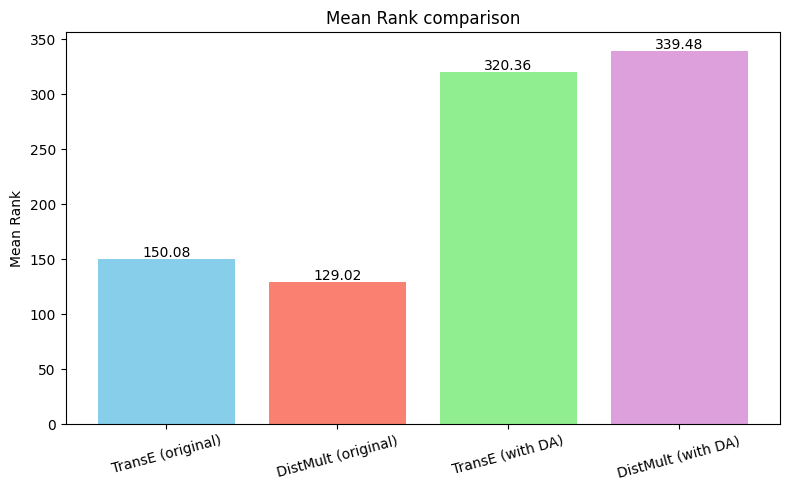

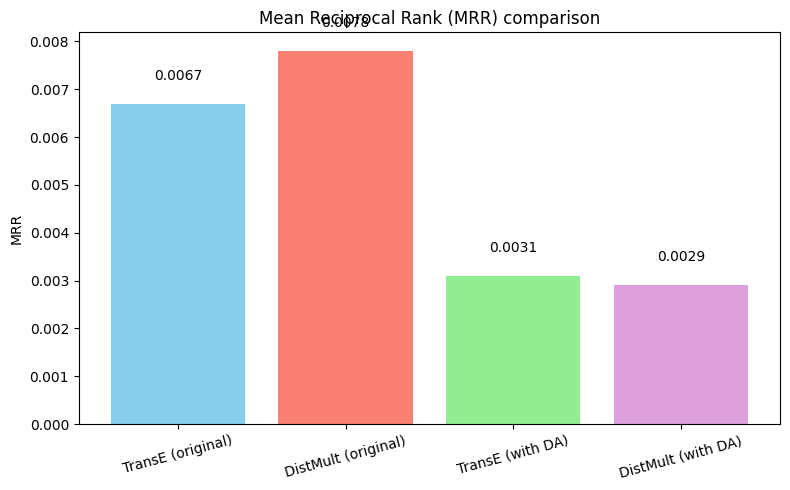

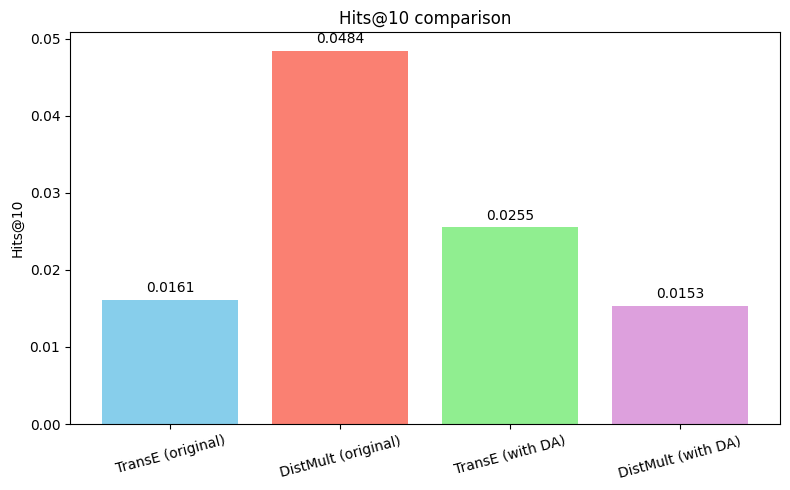

In [57]:
# Model names
models = ['TransE (original)', 'DistMult (original)', 'TransE (with DA)', 'DistMult (with DA)']

# Metrics for each model
mean_rank = [150.0806, 129.0161, 320.3622, 339.4847]
mrr = [0.0067, 0.0078, 0.0031, 0.0029]
hits_at_10 = [0.0161, 0.0484, 0.0255, 0.0153]

colors = ['skyblue', 'salmon', 'lightgreen', 'plum']

# Barplot 1 - Mean Rank
plt.figure(figsize=(8, 5))
bars1 = plt.bar(models, mean_rank, color=colors)
plt.title("Mean Rank comparison")
plt.ylabel("Mean Rank")
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, f'{height:.2f}', ha='center')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Barplot 2 - Mean Reciprocal Rank (MRR)
plt.figure(figsize=(8, 5))
bars2 = plt.bar(models, mrr, color=colors)
plt.title("Mean Reciprocal Rank (MRR) comparison")
plt.ylabel("MRR")
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.0005, f'{height:.4f}', ha='center')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Barplot 3 - Hits@10
plt.figure(figsize=(8, 5))
bars3 = plt.bar(models, hits_at_10, color=colors)
plt.title("Hits@10 comparison")
plt.ylabel("Hits@10")
for bar in bars3:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.001, f'{height:.4f}', ha='center')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

The results show quite an unexpected behavior regarding the impact of data augmentation on model quality.

Without data augmentation, the original DistMult achieves the best overall performance: its arithmetic mean rank is the lowest (129.01), meaning that the correct answers are, on average, better ranked. It is also the only model to reach a relatively high hits@10 (4.84%), indicating that it manages to place correct triplets in its top 10 predictions more often than the others.

On the other hand, adding external data through DBpedia does not seem to have improved the results. Quite the opposite, the performance has deteriorated for both models. The mean rank increases significantly for both TransE (from 150.08 to 320.36) and DistMult (from 129.01 to 339.48), indicating a decrease in precision. MRR and hits@10 also follow this trend, both dropping after the integration of DBpedia triples.

This suggests that the added entities or relations have likely introduced noise or semantic ambiguities, making the learning of representations more difficult. Naive enrichment, without proper disambiguation, can thus harm the quality of the embeddings. A more selective filtering strategy or more robust linking would be necessary to leverage data augmentation effectively.

## **3- Before/After Differences**

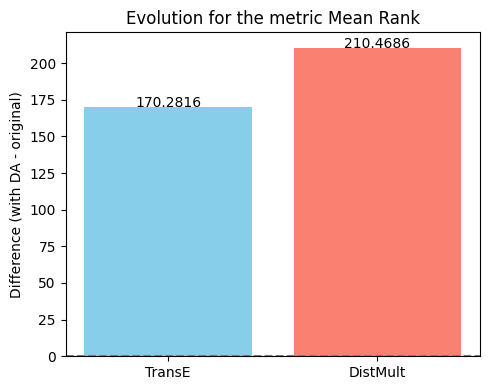

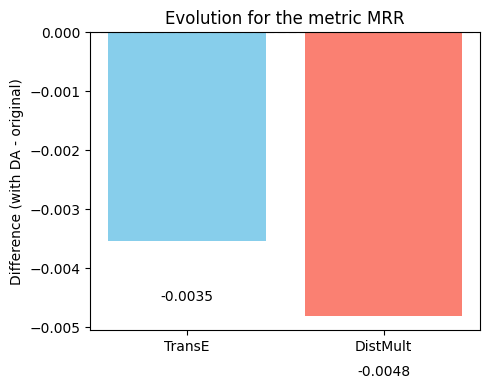

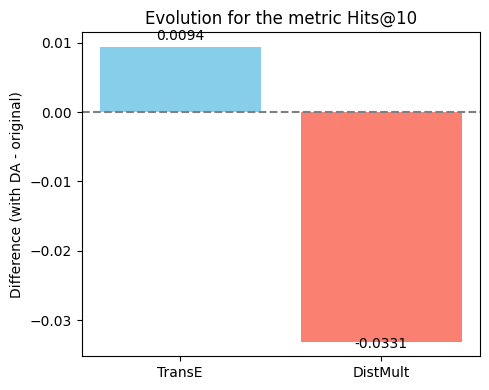

In [58]:
results_dict = {
    'TransE': results_transE,
    'DistMult': results_distmult,
    'TransE (DA)': results_transE_data_augmentation,
    'DistMult (DA)': results_distmult_data_augmentation
}

metrics = ['arithmetic_mean_rank', 'inverse_arithmetic_mean_rank', 'hits_at_10']
metric_names = ['Mean Rank', 'MRR', 'Hits@10']

scores = {}
for model_name, result in results_dict.items():
    values = result.metric_results.to_dict()['both']['realistic']
    scores[model_name] = [values[m] for m in metrics]

# Calculation of differences (DA - original)
diffs = {
    'TransE': np.array(scores['TransE (DA)']) - np.array(scores['TransE']),
    'DistMult': np.array(scores['DistMult (DA)']) - np.array(scores['DistMult'])
}

# Graph by metric
for i, metric in enumerate(metric_names):
    plt.figure(figsize=(5, 4))
    vals = [diffs['TransE'][i], diffs['DistMult'][i]]
    bars = plt.bar(['TransE', 'DistMult'], vals, color=['skyblue', 'salmon'])
    
    plt.title(f"Evolution for the metric {metric}")
    plt.ylabel(f"Difference (with DA - original)")
    plt.axhline(0, color='gray', linestyle='--')

    for bar in bars:
        height = bar.get_height()
        offset = 0.001 if height >= 0 else -0.001
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"{height:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

The visualizations clearly show that adding data through DBpedia (data augmentation) has had a negative impact on the performance of both models, TransE and DistMult.

For the **Mean Rank** metric, there is a noticeable degradation after enrichment, with an increase of 170 points for TransE and over 210 points for DistMult. This indicates that the correctly predicted entities are now further down the rankings, reflecting a decrease in precision.

Regarding the **MRR** (Mean Reciprocal Rank), both models also experience a slight decline. DistMult is more affected, losing 0.0048, which could indicate that it had a better ability to capture the original structure of the graph, but the addition of external information introduced noise.

Finally, for the **Hits@10** metric, the effects are contrasting. TransE's score improves slightly, suggesting that it has learned new interesting associations through the enrichment. On the other hand, DistMult’s score drops significantly, losing over 3 percentage points, which suggests that the model was disrupted by the new entities and relations added.

Overall, these results suggest that data augmentation does not always have a beneficial effect. While it can enrich the graph, it can also introduce ambiguity or noise, especially if the integration is not accompanied by thorough semantic cleaning or filtering.

## **4- Spider Chart**

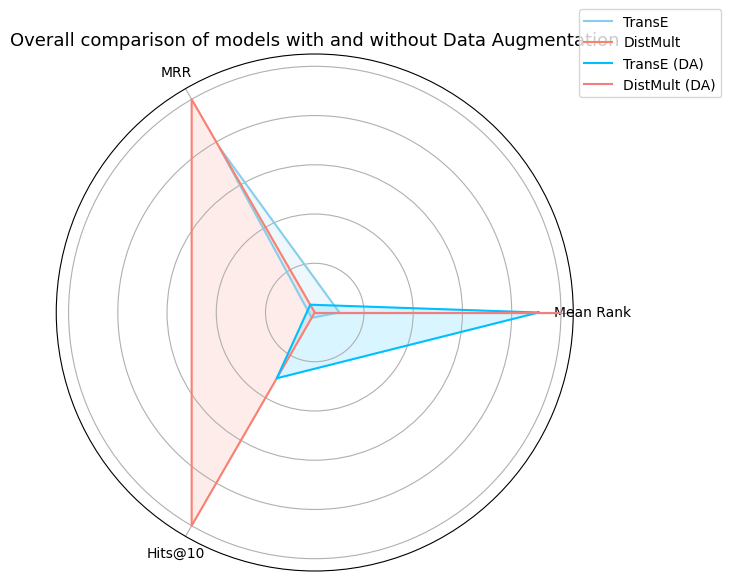

In [59]:
metrics = ['arithmetic_mean_rank', 'inverse_arithmetic_mean_rank', 'hits_at_10']
labels = ['Mean Rank', 'MRR', 'Hits@10']

# Function to extract metrics
def get_metrics(results_dict):
    return [
        results_dict.metric_results.to_dict()["both"]["realistic"][m]
        for m in metrics
    ]

# Extraction of results
values_transE = get_metrics(results_transE)
values_distmult = get_metrics(results_distmult)
values_transE_DA = get_metrics(results_transE_data_augmentation)
values_distmult_DA = get_metrics(results_distmult_data_augmentation)

# Value normalization (for better radar readability)
def normalize(values):
    return [(v - min(values)) / (max(values) - min(values)) for v in values]

# Independent standardization for each metric
all_values = np.array([values_transE, values_distmult, values_transE_DA, values_distmult_DA])
normalized = np.array([normalize(all_values[:, i]) for i in range(3)]).T

# Preparing the radar chart
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1] 

model_names = ["TransE", "DistMult", "TransE (DA)", "DistMult (DA)"]
colors = ['skyblue', 'salmon', 'deepskyblue', 'lightcoral']

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

for i, values in enumerate(normalized):
    data = values.tolist() + values[:1].tolist() 
    ax.plot(angles, data, label=model_names[i], color=colors[i])
    ax.fill(angles, data, alpha=0.15, color=colors[i])

ax.set_title("Overall comparison of models with and without Data Augmentation", size=13)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticklabels([])
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

The spider chart provides a **holistic comparison** of the performance across all four model configurations—**TransE**, **DistMult**, and their augmented counterparts—based on three key metrics: **Mean Rank**, **MRR**, and **Hits@10**.

It’s evident that the **original TransE** (light blue) demonstrates a balanced performance, forming a decently shaped polygon, particularly along the **MRR** and **Hits@10** axes. However, when we look at **TransE (DA)** (dark blue), the shape collapses inward, particularly on the **MRR** and **Hits@10** dimensions, indicating a **notable drop in precision** due to the data augmentation.

On the other hand, **original DistMult** (light red) stands out with the most expansive coverage in the chart. It performs **exceptionally well** on **MRR** and **Hits@10**, giving it a strong, outward-stretched shape. But this advantage diminishes significantly for **DistMult (DA)** (dark red), which shows a **major contraction**, particularly on **Hits@10**, where the drop is sharp.

In summary, this radar plot visually confirms that **data augmentation negatively impacted both models' performance**, especially **DistMult**, which originally performed the best. The **shrinking** of the polygons after augmentation serves as a **clear visual indicator** of degraded results.

# **PART 4: Conclusion & Reflexion**

## **1- Reflections**

When comparing the models with and without data augmentation using DBpedia, one might expect that adding external knowledge would naturally improve performance across all metrics. However, our experiments revealed the opposite. In both TransE and DistMult models, the introduction of data augmentation led to a deterioration in key performance metrics such as Mean Reciprocal Rank (MRR) and Hits@10, and a noticeable increase in Mean Rank. This was surprising, as the enriched graph theoretically contains more semantic context and a broader set of relationships that could benefit link prediction and entity similarity tasks.

One possible explanation for this drop in performance is the nature of the added data. The external triplets retrieved from DBpedia may not have been tightly aligned with the core structure or semantics of the BBC knowledge graph we originally built. Without precise entity linking or semantic filtering, the integration of loosely related or noisy entities could have introduced ambiguity, making it harder for the embedding models to capture consistent patterns. Additionally, the new entities introduced by DBpedia might have disrupted the local neighborhoods of important nodes, resulting in embeddings that are more dispersed and less informative for specific tasks. This shows that data augmentation must be handled carefully, and that quantity alone does not guarantee quality.

## **2- Final Conclusion**

In this second part of the project, focused on Knowledge Graph Embedding, we explored how to generate vector representations of entities from our RDF graph using two popular embedding models: TransE and DistMult. After converting our RDF graph into a format compatible with PyKEEN, we split the data into training, validation, and testing sets. We then trained both models, evaluated their performance using standard metrics (Mean Rank, MRR, Hits@10), and visualized the embeddings using t-SNE. We also performed qualitative analyses to interpret both correct and incorrect predictions made by each model, providing deeper insight into their behavior.

In the second half of the pipeline, we introduced data augmentation by enriching our graph with external knowledge extracted from DBpedia via SPARQL queries. We selected candidate entities, cleaned them, integrated new triplets into the original RDF graph, and repeated the entire embedding pipeline on the extended dataset. This allowed us to rigorously compare the impact of external knowledge on embedding quality, both quantitatively (through metric comparison and visualizations) and qualitatively (via prediction examples and embedding maps).

Overall, the process allowed us to understand not only how different models behave, but also how knowledge integration from heterogeneous sources can affect downstream embedding performance.

## **3- Possible Improvements**

There are several ways this project could be further improved. First and foremost, the data augmentation strategy could benefit from more precise entity linking. Instead of using simple string cleaning and name matching, we could incorporate Named Entity Disambiguation tools to map local entities to DBpedia or Wikidata entities more accurately. This would help avoid adding irrelevant or weakly related facts to the graph.

Additionally, we could apply more advanced filtering mechanisms to keep only semantically strong and useful relationships during the enrichment phase. On the modeling side, experimenting with more recent or complex embedding algorithms (such as RotatE, ConvE, or ComplEx) might yield better performance, especially on enriched graphs. We could also introduce hyperparameter optimization to fine-tune the model settings for each dataset.

Finally, moving beyond static embeddings, incorporating temporal or contextual dimensions—especially for news-related graphs—could open new avenues for capturing evolving relationships and trends over time.